<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/External_Access_to_Amazon_Braket_with_qiskit_braket_provider_mkbahk_20241102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 작업순서
1. Amazon Braket 환경 설정(확인만)
2. S3 환경설정(확인만)
3. (중요) IAM을 이용한 Access Key 설정 및 권한 부여
4. 원격 작업
5. 각종 로그 보기
6. 작업 환경 정리


In [13]:
!pip install git+https://github.com/qiskit-community/qiskit-braket-provider.git

  Cloning https://github.com/qiskit-community/qiskit-braket-provider.git to /tmp/pip-req-build-_9c1gja4
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-braket-provider.git /tmp/pip-req-build-_9c1gja4
  Resolved https://github.com/qiskit-community/qiskit-braket-provider.git to commit 1fd281925027ecfa690f5400f12a8dfac59ee014
  Preparing metadata (setup.py) ... done


In [14]:
#!pip install amazon-braket-sdk==1.94.0
#!python3 -m pip install boto3
#!python3 -m pip install botocore

In [15]:
%pip show qiskit
%pip show qiskit-braket-provider
%pip show amazon-braket-sdk

Name: qiskit
Version: 1.4.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-ionq, qiskit_braket_provider
Name: qiskit_braket_provider
Version: 0.4.6
Summary: Qiskit-Braket provider to execute Qiskit programs on AWS quantum computing hardware devices through Amazon Braket.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: amazon-braket-sdk, certifi, numpy, qiskit, qiskit-ionq, setuptools
Required-by: 
Name: amazon-braket-sdk
Version: 1.95.0
Summary: An open source library for interacting with quantum computing devices on Amazon Braket
Home-page: 

In [16]:
from braket.experimental_capabilities import EnableExperimentalCapability

In [17]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [21]:
import os
# Set environment variables for AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""
os.environ['AWS_DEFAULT_REGION'] = "us-east-1"

# You can optionally set the s3 bucket and prefix using environment variables
#os.environ['AWS_BRAKET_S3_BUCKET'] = "snuqc"
#os.environ['AWS_BRAKET_S3_PREFIX'] = "amazonbraket"

In [22]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()
#local_sv_simulator = BraketLocalBackend(name='braket_sv')
#local_dm_simulator = BraketLocalBackend(name='braket_dm')

In [23]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()
#provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
#provider.backends(statuses=["ONLINE"], types=["QPU"])
provider.backends(statuses=["ONLINE"], types=["SIMULATOR", "QPU"])

[BraketBackend[Ankaa-3],
 BraketBackend[Forte Enterprise 1],
 BraketBackend[Garnet],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

In [24]:
#backend = provider.get_backend("Aria 1")
#backend = provider.get_backend("Aria 2")
#backend = provider.get_backend("Forte 1")

#backend= provider.get_backend("Ankaa-2")
#backend = provider.get_backend("Aspen-M-3")

#Ibackend = provider.get_backend("Garnet")

backend = provider.get_backend("SV1")
#backend = provider.get_backend("dm1")
#backend = provider.get_backend("TN1")

In [25]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.measure_all()


In [35]:
circuit.draw()

┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

In [27]:
from qiskit.compiler import transpile, assemble
trans_qc = transpile(circuit, backend)
trans_qc.draw()

┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

In [28]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=1024)

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 지속적인 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(2)
###while

/usr/local/lib/python3.11/dist-packages/qiskit_braket_provider/providers/adapter.py:582: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


Job ID is arn:aws:braket:us-east-1:590183937332:quantum-task/cea2d2b9-8015-4e03-a159-5a26573a904a 



In [29]:
print("Job status is", job.status() )

Job status is JobStatus.DONE


In [30]:
# 중간에 세션이 종료된 경우 기존에 실행이 완료된 Job을 복구하는 방법
#job = backend.retrieve_job("arn:aws:braket:us-east-1:746669231099:quantum-task/f6fab6be-1590-4da0-914a-fade74efc485")

In [31]:
result = job.result()
result

Result(backend_name='SV1', backend_version='2', qobj_id='0', job_id='arn:aws:braket:us-east-1:590183937332:quantum-task/cea2d2b9-8015-4e03-a159-5a26573a904a', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'000': 512, '111': 512}, memory=['000', '000', '111', '111', '111', '000', '111', '000', '111', '000', '111', '000', '000', '000', '000', '111', '000', '111', '000', '111', '111', '111', '000', '000', '111', '000', '000', '000', '111', '000', '111', '111', '111', '000', '111', '111', '000', '111', '000', '000', '000', '111', '111', '000', '111', '000', '000', '000', '000', '111', '000', '000', '000', '111', '000', '000', '111', '000', '000', '111', '111', '000', '000', '000', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '000', '111', '111', '111', '000', '000', '111', '111', '111', '000', '111', '000', '111', '111', '111', '111', '111', '000', '111', '000', '111', '111', '000', '111', '111', '

In [32]:
# 결과 출력
counts = result.get_counts()
print(counts)

{'000': 512, '111': 512}


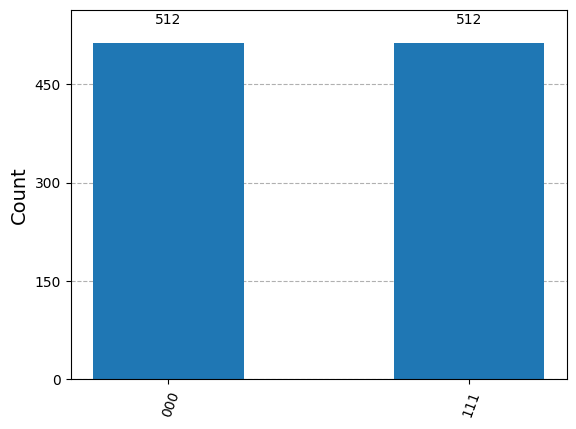

In [33]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [ ]:
print("Quantum Task Summary\n")
print(t.quantum_tasks_statistics())
print('\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. \nEstimated charges shown may differ from your actual charges. \nEstimated charges do not factor in any discounts or credits, \nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"\nEstimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary

{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1024, 'tasks': {'COMPLETED': 1}, 'execution_duration': datetime.timedelta(microseconds=3000), 'billed_execution_duration': datetime.timedelta(seconds=3)}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. 
Estimated charges shown may differ from your actual charges. 
Estimated charges do not factor in any discounts or credits, 
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 0.00 USD
